## Mini Projet Apprentissage Artificel : Groupe Paul Garnier - Arthur Verrez

(à rendre pour le vendredi 16/11/18)

Choix du sujet : Transfer Learning 

Nous allons utiliser le ConvNet construit par Google et notamment François Chollet : [Papier d'origine](https://arxiv.org/abs/1610.02357)

Le réseau se base sur des modules, que l'on présente ci-dessous : 

![inception-module](inception-module.png "Module Inception V3")

Chacun de ces modules vont "s'empiler" pour former notre réseau total. On présente sa forme complète ci-dessous : 

![xception](xception.png "Xception ConvNet")

C'est un réseau qui obtient de très bonnes performances, tout en limitant son nombre de paramètres (22 millions de paramètres). 

![xception-resultats](xception-resultats.png "Xception ConvNet")

## Mise en place du modèle : 

Nous allons commencer par mettre en place nos ConvNet, ainsi que les modules dont nous auront besoin : 

In [2]:
## Imports des différents modules, hors Keras: 
## ===============================

import os
import copy
import sys

# et pour l'affichage : 

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# Pour Keras : 


from keras import backend as K
from keras import __version__

# Pour charger notre modèle : 
from keras.applications.xception import Xception, preprocess_input
from keras.models import Model
from keras.models import load_model

# Pour modifier notre modèle : 

from keras.layers import Dense, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, Input, Flatten, Dropout
from keras.optimizers import SGD

# Pour modifier nos images et les utiliser : 

from keras.preprocessing.image import ImageDataGenerator
print("done.")

/Users/paulgarnier/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


done.


Nous allons maintenant configurer les paramètres que nous allons utiliser :  

In [4]:
WIDTH, HEIGHT = 299, 299 #fixed size for InceptionV3
CHANNEL = 3
NB_EPOCHS = 10
BAT_SIZE = 16
FC_SIZE = 1024
NB_IMG_TRAIN = 200
NB_IMG_VAL = 40
BAT_SIZE_TEST = 4
nb_classes = 7
print("done.")

done.


On peut maintenant charger notre modèle : 

In [5]:
model_xception = Xception(input_tensor = Input(shape=(WIDTH,HEIGHT,CHANNEL)),
                          weights='imagenet', # On le prend, pre-trained sur imagesnet. 
                          include_top=False) # Pour enlever la couche Dense(1000) de classification
print("done.")

done.


On va maintenant construire nos fonctions pour le transfer learning. 

Globalement, cela représente : 

- une fonction pour modifier notre réseau (changer les dernières couches)
- une fonction pour freeze l'entrainement de toutes les couches, sauf la dernière
- une fonction pour freeze l'entrainement d'une nombre choisit de couches (fine tunning)


In [6]:
"""
On rajoute des nouvelles couches à notre modèle, et on le retourne

"""

def nouvelle_couche(model, nb_classes):
    x = model.output
    x = AveragePooling2D((10,10), padding='valid')(x) # On place un avg_pooling de taille 10x10 pour limiter les paramètres
    x = Dropout(0.7)(x) # On place du dropout, pour éviter l'overfitting.
    x = Flatten()(x) 
    x = Dense(2048,activation='relu')(x)
    x = Dropout(0.7)(x)
    predictions = Dense(nb_classes, activation='softmax')(x)
    new_model = Model(inputs=model.input, outputs=predictions)
    return new_model

print("done.")

done.


In [7]:
"""
On freeze l'intégralité des couches de notre premier modèle : ici le xception.
On compile ensuite notre modèle total et on affiche sa structure.
On renvoie aussi le nombre de couches.
"""

def freeze_full(new_model, model): 
    print("Nombre de couche dans le modèle de base := {}".format(len(model.layers)))
    for layer in model.layers:
        layer.trainable = False
    new_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    new_model.summary()
    
print("done.")

done.


In [8]:
"""
Ici, on ne freeze les couches que jusqu'à un certains index : 
"""

def freeze_some(new_model,model,indx):
    cpt = 0
    for layer in model.layers:
        layer.trainable = False
        cpt+=1
        if cpt > indx:
            break 
    new_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    new_model.summary()
    
print("done.")

done.


Il reste maintenant à mettre en place tout notre modèle.
Pour l'instant, on évite des choix de paramètres tricky, et on freeze tout le Xception de départ : 

In [9]:
# On rajoute nos couches à la fin 

model = nouvelle_couche(model_xception, nb_classes)

# On met en place le freeze, jusqu'à la couche 127. 

freeze_full(model,model_xception)
#freeze_some(model,model_xception,127)

Nombre de couche dans le modèle de base := 132
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________

## Mise en place du dataset  : 

Nous nous intéressons au fait de pouvoir différencier des plats culinaires, nous nous sommes notamment concentré sur la reconnaissance des plats suivants:

-des Hamburgers:
![title](img/h1.jpg)
![title](img/h2.jpg)

-des pates
![title](img/p1.jpg)
![title](img/p2.jpg)

-des sushis ainsi que des makis
![title](img/su1.jpg)
![title](img/su2.jpg)

-des baozhi
![title](img/b1.jpg)
![title](img/b2.jpg)

-des soupes de ramen
![title](img/r1.jpg)
![title](img/r2.jpg)

-et de la salade
![title](img/s1.jpg)
![title](img/s2.jpg)


Pour chacune de ces 6 catégories, nous avons sélectionné 50 images d'entrainement et 10 images de validation. Cependant, il est important de noter que chacun de ces dataset présentent des images très différentes (par exemple des pâtes à la carbonara ou des pâtes au pesto), avec différents points de vus et éclairages.


On va utiliser les fonctionnalités de Keras, on énonce d'abord nos différents paramètres : 

In [12]:
## Pour l'entrainement : 
#On limite ces paramètre, comme on travail sur des visages.

# ======================


rotationTrain = 30 
width_shiftTrain = 0.2
height_shiftTrain = 0.2
shearTrain = 0.1
zoomTrain = 0.05
flipTrain = False

## Pour les test : 

# ==============

rotationTest = 0. 
width_shiftTest = 0.1
height_shiftTest = 0.1
shearTest = 0.1
zoomTest = 0.05
flipTest = False

print("done.")

done.


On peut maintenant créer nos différents [ImageDataGenerator](https://keras.io/preprocessing/image/)
Les data pour les tests et la validation seront les même. 

In [13]:


trainDataGenerator = ImageDataGenerator(
        rotation_range= rotationTrain,
        width_shift_range= width_shiftTrain,
        height_shift_range= height_shiftTrain,
        shear_range= shearTrain,
        zoom_range= zoomTrain,
        rescale=1./255,
        horizontal_flip= flipTrain,
        vertical_flip =  flipTrain,
        fill_mode='nearest')

testDataGenerator = ImageDataGenerator(
        rotation_range= rotationTest,
        width_shift_range= width_shiftTest,
        height_shift_range= height_shiftTest,
        shear_range= shearTest,
        zoom_range= zoomTest,
        rescale=1./255,
        horizontal_flip= flipTest,
        vertical_flip = flipTest,
        fill_mode='nearest')

print("done.")

done.


Les data sont en .zip sur GitHub. 
Elles sont placées en 2 dossiers : un training, et un validation. 
Chacun de ces deux dossiers comprend ensuite 4 dossiers : angry, frigthened, happy et neutral.

Ces différents dossiers comprennent les images que nous allons utiliser. 

## On met ici en place les directions pour ces dossiers (à changer modifier)

In [14]:


trainImg = '/Users/paulgarnier/Desktop/Files/Cours/Mines/2A/ApprentissageArtificiel/training/' 
validationImg = '/Users/paulgarnier/Desktop/Files/Cours/Mines/2A/ApprentissageArtificiel/validation/'

print("done.")

done.


Finalement, on lance nos dataGenerator avec ces images :  

In [15]:

trainGenerator = trainDataGenerator.flow_from_directory(
                    trainImg,
                    target_size=(WIDTH,HEIGHT),
                    batch_size=BAT_SIZE,
                    color_mode='rgb',
                    class_mode='categorical')
testGenerator = testDataGenerator.flow_from_directory(
                    validationImg,
                    target_size=(WIDTH,HEIGHT),
                    batch_size=BAT_SIZE_TEST,
                    color_mode='rgb',
                    class_mode='categorical') 
print("done.")

Found 350 images belonging to 7 classes.
Found 70 images belonging to 7 classes.
done.


## Entraînement du modèle : 

On peut maintenant entrainer le modèle, puis analyser nos résultats. 
On définit tout d'abord le nom de notre modèle pour pouvoir le sauvegarder sur notre ordinateur.

In [16]:
saveName = "xception_face.model"
print("done.")

done.


In [17]:
## et on lance le training : 
## ========================

history = model.fit_generator(trainGenerator,
                              steps_per_epoch=NB_IMG_TRAIN/BAT_SIZE,
                              epochs=50,
                              validation_data=testGenerator,
                              validation_steps=NB_IMG_VAL/BAT_SIZE_TEST,
                                 verbose=1) 


model.save(saveName)
print("done.")

Epoch 1/50
13/12 [===============================] - 81s 6s/step - loss: 2.4247 - acc: 0.2163 - val_loss: 1.9575 - val_acc: 0.4250
Epoch 2/50
13/12 [===============================] - 76s 6s/step - loss: 2.0328 - acc: 0.3730 - val_loss: 1.2130 - val_acc: 0.5526
Epoch 3/50
13/12 [===============================] - 78s 6s/step - loss: 1.2406 - acc: 0.5288 - val_loss: 0.7708 - val_acc: 0.7750
Epoch 4/50
13/12 [===============================] - 75s 6s/step - loss: 1.2089 - acc: 0.5289 - val_loss: 0.7811 - val_acc: 0.7632
Epoch 5/50
13/12 [===============================] - 79s 6s/step - loss: 1.0723 - acc: 0.6298 - val_loss: 0.7173 - val_acc: 0.8000
Epoch 6/50
13/12 [===============================] - 76s 6s/step - loss: 0.9222 - acc: 0.6937 - val_loss: 0.5998 - val_acc: 0.7895
Epoch 7/50
13/12 [===============================] - 76s 6s/step - loss: 1.0671 - acc: 0.6353 - val_loss: 0.7143 - val_acc: 0.8000
Epoch 8/50
13/12 [===============================] - 77s 6s/step - loss: 0.8679 - a

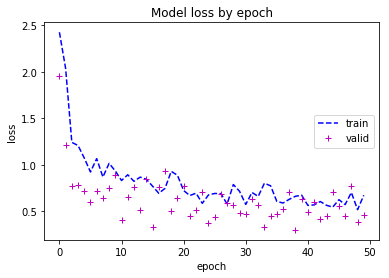

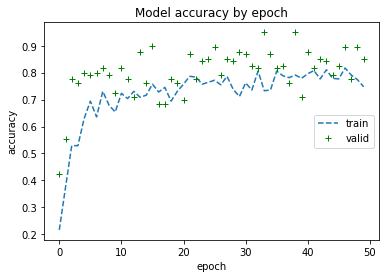

In [21]:
plt.plot(history.history['loss'],'b--')
plt.plot(history.history['val_loss'],'m+')
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')
plt.show()

plt.plot(history.history['acc'],'--')
plt.plot(history.history['val_acc'],'g+')
plt.title('Model accuracy by epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'valid'], loc='right')
plt.xlabel('epoch')
plt.show()


On reload notre modèle pour pouvoir le réutiliser par la suite : 

In [25]:
traine_model = load_model('xception_face.model')
print("done.")

done.
